In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
import pydub
import os
import glob


In [21]:
class Clip:
    """A single 5-sec long recording."""
    
    RATE = 44100   # All recordings in ESC are 44.1 kHz
    FRAME = 512    # Frame size in samples
    
    class Audio:
        """The actual audio data of the clip.
        
            Uses a context manager to load/unload the raw audio data. This way clips
            can be processed sequentially with reasonable memory usage.
        """
        
        def __init__(self, path):
            self.path = path
        
        def __enter__(self):
            # Actual recordings are sometimes not frame accurate, so we trim/overlay to exactly 5 seconds
            audio_segment = pydub.AudioSegment.from_file(self.path)
            audio_segment = audio_segment.set_frame_rate(Clip.RATE).set_channels(1).set_sample_width(2)
            audio_segment = audio_segment[:5000]  # Trim or overlay to exactly 5 seconds

            self.data = pydub.AudioSegment.silent(duration=5000).overlay(audio_segment)
            self.raw = (np.frombuffer(self.data.raw_data, dtype=np.int16) + 0.5) / (0x7FFF + 0.5)  # convert to float
            return self
        
        def __exit__(self, exception_type, exception_value, traceback):
            if exception_type is not None:
                print(exception_type, exception_value, traceback)
            del self.data
            del self.raw
        
    def __init__(self, filename):
        self.filename = os.path.basename(filename)
        self.path = os.path.abspath(filename)        
        self.directory = os.path.dirname(self.path)
        self.category = self.directory.split('/')[-1]
        
        self.audio = Clip.Audio(self.path)
        
        with self.audio as audio:
            self._compute_mfcc(audio)    
            self._compute_zcr(audio)

    # LEGACY CODE      
    # def _compute_mfcc(self, audio):
    #     # MFCC computation with default settings (2048 FFT window length, 512 hop length, 128 bands)
    #     self.melspectrogram = librosa.feature.melspectrogram(audio.raw, sr=Clip.RATE, hop_length=Clip.FRAME)
    #     self.logamplitude = librosa.logamplitude(self.melspectrogram)
    #     self.mfcc = librosa.feature.mfcc(S=self.logamplitude, n_mfcc=13).transpose()
    
    def _compute_mfcc(self, audio):
    # MFCC computation with default settings (2048 FFT window length, 512 hop length, 128 bands)
        self.melspectrogram = librosa.feature.melspectrogram(y=audio.raw, sr=Clip.RATE, hop_length=Clip.FRAME)
        self.logamplitude = librosa.amplitude_to_db(self.melspectrogram)
        self.mfcc = librosa.feature.mfcc(S=self.logamplitude, n_mfcc=13).transpose()

            
    def _compute_zcr(self, audio):
        # Zero-crossing rate
        self.zcr = []
        frames = int(np.ceil(len(audio.data) / 1000.0 * Clip.RATE / Clip.FRAME))
        
        for i in range(0, frames):
            frame = Clip._get_frame(audio, i)
            self.zcr.append(np.mean(0.5 * np.abs(np.diff(np.sign(frame)))))

        self.zcr = np.asarray(self.zcr)
            
    @classmethod
    def _get_frame(cls, audio, index):
        if index < 0:
            return None
        return audio.raw[(index * Clip.FRAME):(index+1) * Clip.FRAME]
    
    def __repr__(self):
        return '<{0}/{1}>'.format(self.category, self.filename)

In [5]:
import seaborn as sb
sb.set(style="white", palette="muted")

In [6]:
import random
random.seed(20150420)

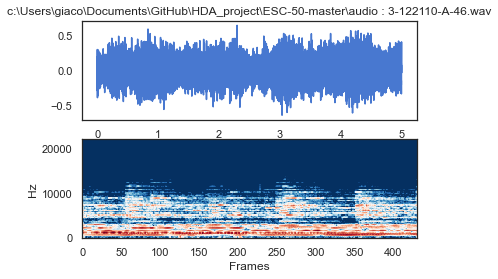

In [30]:
import IPython.display

all_recordings = glob.glob('ESC-50-master\\audio\\*.wav')
clip = Clip(all_recordings[random.randint(0, len(all_recordings) - 1)])    

with clip.audio as audio:
    plt.subplot(2, 1, 1)
    plt.title('{0} : {1}'.format(clip.category, clip.filename))
    plt.plot(np.arange(0, len(audio.raw)) / 44100.0, audio.raw)
   
    plt.subplot(2, 1, 2)
    librosa.display.specshow(clip.logamplitude, sr=44100, x_axis='frames', y_axis='linear', cmap='RdBu_r')
    
IPython.display.Audio(filename=clip.path, rate=Clip.RATE)    
